#Find the nuclei in divergent images to advance medical discovery

In this dataset we will classify microscopic images of Nucleus  from the 2018 data  Data Science Bowl [Find the nuclei in divergent images to advance medical discovery ](http://www.kaggle.com/c/data-science-bowl-2018) dataset.This dataset contains a large number of segmented nuclei images.  You'll preprocess the images, then train a U-net convolutional neural network on all the samples. The images need to be normalize and we use Data augmentation because we have small dataset. we are apply convolutional, max pooling,concatenate and upsampling At the end, you'll get to see your neural network's predictions on the sample images.
# Get the data
You can download the data hear- [Find the nuclei in divergent images to advance medical discovery ](https://www.kaggle.com/c/data-science-bowl-2018/data)



In [1]:
!pip install tqdm
!curl -LO https://raw.github.com/drj11/pypng/master/code/png.py

import numpy as np 
import pandas as pd
import sys
from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize 
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
import keras.backend as K
np.random.seed(14)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   97k  100   97k    0     0    97k      0  0:00:01 --:--:--  0:00:01   97k


Using TensorFlow backend.


In [2]:
cwd = os.getcwd()

testpath = os.path.join(cwd, 'data', 'test')
trainpath = os.path.join(cwd, 'data', 'train')

if not os.path.exists(trainpath):
    os.makedirs(trainpath)

if not os.path.exists(testpath):
    os.makedirs(testpath)

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

test_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1527516301&Signature=PsQNWaZzX60IZTGFDisXXn3RVGSm6VqYHdNlhzA4U2kSZ5o86ANFFENXvFDHdf75f8%2F0chchV0pff01MtP309BPULgddPzFcrdu1fap3Ud1D81ToJ%2BZWdDqVc3CVqmS0AtRjeQbSReuuDuoS1%2Ff%2B%2BHWOtUjbYdhMeVjy7ptLzt7XTezLpiUZ54biU2Wg%2BW7Vp6PDXJXB7Izeg%2FI0kvqivCk6XWH6Dy%2B5U%2FJDKVchr2Q%2B6tbmJsHal8wRXWYPCMuSrZrKhNde9la6BWcBdgSxcc7L7bMBzi6unx4Hu7xzJV%2FlbbbRyT1ESzQmoO39enytA47BDiihWRK0ZDh9eQ%2FSAg%3D%3D'      
train_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1527516252&Signature=MP2TYKkHKpn2UmfHYDsZP5YI1ZPXE09%2BzVEtCdBTI6PHO1OWCngiejipodK0xj2DMdh6Z6flsrK3J8ilBZ%2Be%2Fw1brci476y9Id1euMW8XjeEWOPrFKbmmmw%2FH3JrrTjTM3ynb%2BviaD4q4eutyvARureOPdRvLKRhRzpvj035%2FTrbKebHIN7pEq9EP3fdtXYOgDudLm0NurLlzF%2BYGLqOBntLBBJ2pU%2BNGOpcrb1cNs7eXc6lslyHYJqETY6YxkEljX0iVIaN%2F1EnlQbAFpOBOMr8q54XqkTDX0%2BybZfS7ke9L6Eu0pIqONePGaPfZnvtPBFGKB54h0jMzYntAbrWMA%3D%3D'
if not isfile('train.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Train Data') as pbar:
        urlretrieve(
            train_url,
            'train.zip',
            pbar.hook)
        
        
if not isfile('test.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Test Data') as pbar:
        urlretrieve(
            test_url,  
            'test.zip',
            pbar.hook)

with zipfile.ZipFile('train.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'train'))
    zip_file.close()

with zipfile.ZipFile('test.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'test'))
    zip_file.close()

print('All files Found')

All files Found


In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 3

TRAIN_PATH =  os.path.join('data', 'train')
TEST_PATH = os.path.join('data', 'test')

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

print('Getting And Resizing Training images and Masks...')
sys.stdout.flush()

for index, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img = imread(os.path.join(path, 'images', id_) +  '.png')[:, :, :IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range=True)
    X_train[index] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
        mask_ = imread(os.path.join(path, 'masks', mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_HEIGHT), mode = 'constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[index] = mask

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype = np.uint8)
    
print('Getting And Resizing Testing images and Masks...')
sys.stdout.flush()

for index, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(os.path.join(path, 'images', id_) +  '.png')[:, :, :IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range=True)
    X_test[index] = img

print('done')
print('We have {} Train images and {} Test images!'.format(X_train.shape[0],  X_test.shape[0]))

Getting And Resizing Training images and Masks...


100%|██████████| 670/670 [01:48<00:00,  6.18it/s]

Getting And Resizing Testing images and Masks...



100%|██████████| 65/65 [00:00<00:00, 68.34it/s]

done
We have 670 Train images and 65 Test images!


# Visulization Images And Masks
We have 670 Training examples, now i am generating random index and visulize images and mask, i make `display_images` method, this method has three inputs, `X_train`, `Y_train` and `id_`. the `id_` input conain indexes. i am randomly generate id_ and visulize images and mask, run below comand.

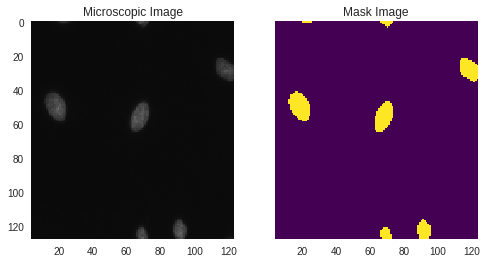

In [5]:
def display_images(id_, X_train, Y_train):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
    ax1.set_title('Microscopic Image')
    ax1.grid(False)
    ax1.imshow(X_train[id_])

    ax2.set_title('Mask Image')
    ax2.grid(False)
    ax2.imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    plt.show()

id_ = np.random.randint(len(X_train))
display_images(9, X_train, Y_train)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `X_train and X_test`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `X_train and X_test`.

In [0]:
def normalize(x):
    samples = []
    for sample in x:
        samples.append(sample / 255)
    return np.array(samples)

X_train = normalize(X_train)
X_test = normalize(X_test)

# Metrics

This project is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:

\begin{align}
IoU(A,B) = \frac{A \cap B}{ A \cup B}.
\end{align}

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.
At each threshold value tt, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:

\begin{align}
\frac{TP(t)}{TP(t) + FP(t) + FN(t)}.
\end{align}

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:

\begin{align}
\frac{1}{|thresholds|} \sum_t \frac{TP(t)}{TP(t) + FP(t) + FN(t)}.
\end{align}

Lastly, the score returned by the project metric is the mean taken over the individual average precisions of each image in the test dataset.

Reference: 

[https://www.kaggle.com/c/data-science-bowl-2018#evaluation](https://www.kaggle.com/c/data-science-bowl-2018#evaluation)

In [0]:
def IoU(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build the network
In this project we build U-net Convolutional Networks for Image Segmentation.The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin . and we use this CNN archistructure. [Papers](https://arxiv.org/pdf/1505.04597.pdf)
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [8]:
def create_model():
    
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH))
#     x = Lambda(lambda x : x / 255) (inputs)
    
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(conv)
    p = MaxPooling2D((2, 2))(conv)
    
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(p)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    p1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    p2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    p3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv4)
    
    m = concatenate([
        Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv4)),
        conv3
    ])
    
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(m)
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv5)
    
    m1 = concatenate([
        Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv5)),
        conv2
    ])
    
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(m1)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    
    m2 = concatenate([
        Conv2D(32, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv6)),
        conv1
    ])
    
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(m2)
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv7)
    
    m3 = concatenate([
        Conv2D(16, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv7)),
        conv
    ])
    
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(m3)
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv8)
    
    output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(conv8)
    
    model = Model(inputs = inputs, outputs = output)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = [IoU])
    return model
    
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Train the model
Now we train our model, before we train the model we set our callbacks
*   **ModelCheckpoint** :  For example: if filepath  is **model-capstone_project_udacity_by_jimit_jaishwal**, then the model checkpoints will be saved with the epoch number and the validation loss in the filename.
*  **EarlyStopping** : Stop training when a monitored quantity has stopped improving.

In [9]:
stoper = EarlyStopping(verbose=1, patience=7)
FILE_PATH = 'model-capstone_project_udacity_by_jimit_jaishwal.h5'
checkpointer = ModelCheckpoint(FILE_PATH, verbose=1, save_best_only=True)


BATCH = 8
EPOCH = 40

model.fit(epochs= EPOCH, x = X_train,
          y = Y_train, 
          shuffle = False,
          batch_size = BATCH,
          validation_split = 0.1,
          callbacks=[stoper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/40
603/603 [==============================] - 13s 21ms/step - loss: 0.4384 - IoU: 0.4190 - val_loss: 0.2727 - val_IoU: 0.4251

Epoch 00001: val_loss improved from inf to 0.27268, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 2/40
603/603 [==============================] - 9s 15ms/step - loss: 0.2218 - IoU: 0.4379 - val_loss: 0.1465 - val_IoU: 0.4738

Epoch 00002: val_loss improved from 0.27268 to 0.14651, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 3/40
603/603 [==============================] - 9s 15ms/step - loss: 0.1452 - IoU: 0.5175 - val_loss: 0.1245 - val_IoU: 0.5568

Epoch 00003: val_loss improved from 0.14651 to 0.12455, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 4/40
 72/603 [==>...........................] - ETA: 7s - loss: 0.1238 - IoU: 0.5635

603/603 [==============================] - 9s 15ms/step - loss: 0.1184 - IoU: 0.5867 - val_loss: 0.1036 - val_IoU: 0.6129

Epoch 00004: val_loss improved from 0.12455 to 0.10363, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 5/40
603/603 [==============================] - 9s 15ms/step - loss: 0.1034 - IoU: 0.6337 - val_loss: 0.0922 - val_IoU: 0.6527

Epoch 00005: val_loss improved from 0.10363 to 0.09221, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 6/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0945 - IoU: 0.6682 - val_loss: 0.0921 - val_IoU: 0.6823

Epoch 00006: val_loss improved from 0.09221 to 0.09208, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 7/40
200/603 [========>.....................] - ETA: 5s - loss: 0.0835 - IoU: 0.6873

603/603 [==============================] - 9s 15ms/step - loss: 0.0871 - IoU: 0.6940 - val_loss: 0.0918 - val_IoU: 0.7049

Epoch 00007: val_loss improved from 0.09208 to 0.09180, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 8/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0844 - IoU: 0.7139 - val_loss: 0.0833 - val_IoU: 0.7225

Epoch 00008: val_loss improved from 0.09180 to 0.08332, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 9/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0797 - IoU: 0.7299 - val_loss: 0.0816 - val_IoU: 0.7369

Epoch 00009: val_loss improved from 0.08332 to 0.08158, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 10/40
216/603 [=========>....................] - ETA: 5s - loss: 0.0755 - IoU: 0.7397

603/603 [==============================] - 9s 15ms/step - loss: 0.0776 - IoU: 0.7431 - val_loss: 0.0806 - val_IoU: 0.7488

Epoch 00010: val_loss improved from 0.08158 to 0.08063, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 11/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0761 - IoU: 0.7539 - val_loss: 0.0801 - val_IoU: 0.7587

Epoch 00011: val_loss improved from 0.08063 to 0.08008, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 12/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0748 - IoU: 0.7630 - val_loss: 0.0803 - val_IoU: 0.7671

Epoch 00012: val_loss did not improve from 0.08008
Epoch 13/40
240/603 [==========>...................] - ETA: 5s - loss: 0.0721 - IoU: 0.7689

603/603 [==============================] - 9s 15ms/step - loss: 0.0739 - IoU: 0.7708 - val_loss: 0.0792 - val_IoU: 0.7743

Epoch 00013: val_loss improved from 0.08008 to 0.07918, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 14/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0723 - IoU: 0.7775 - val_loss: 0.0827 - val_IoU: 0.7806

Epoch 00014: val_loss did not improve from 0.07918
Epoch 15/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0767 - IoU: 0.7829 - val_loss: 0.0795 - val_IoU: 0.7856

Epoch 00015: val_loss did not improve from 0.07918
Epoch 16/40
336/603 [===============>..............] - ETA: 3s - loss: 0.0721 - IoU: 0.7871

603/603 [==============================] - 9s 15ms/step - loss: 0.0710 - IoU: 0.7881 - val_loss: 0.0778 - val_IoU: 0.7905

Epoch 00016: val_loss improved from 0.07918 to 0.07782, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 17/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0691 - IoU: 0.7929 - val_loss: 0.0782 - val_IoU: 0.7951

Epoch 00017: val_loss did not improve from 0.07782
Epoch 18/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0721 - IoU: 0.7969 - val_loss: 0.0780 - val_IoU: 0.7988

Epoch 00018: val_loss did not improve from 0.07782
Epoch 19/40
352/603 [================>.............] - ETA: 3s - loss: 0.0671 - IoU: 0.8001

603/603 [==============================] - 9s 15ms/step - loss: 0.0676 - IoU: 0.8007 - val_loss: 0.0775 - val_IoU: 0.8026

Epoch 00019: val_loss improved from 0.07782 to 0.07747, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 20/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0668 - IoU: 0.8043 - val_loss: 0.0776 - val_IoU: 0.8060

Epoch 00020: val_loss did not improve from 0.07747
Epoch 21/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0668 - IoU: 0.8076 - val_loss: 0.0789 - val_IoU: 0.8091

Epoch 00021: val_loss did not improve from 0.07747
Epoch 22/40
352/603 [================>.............] - ETA: 3s - loss: 0.0669 - IoU: 0.8101

603/603 [==============================] - 9s 15ms/step - loss: 0.0670 - IoU: 0.8106 - val_loss: 0.0767 - val_IoU: 0.8120

Epoch 00022: val_loss improved from 0.07747 to 0.07668, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 23/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0667 - IoU: 0.8132 - val_loss: 0.0781 - val_IoU: 0.8145

Epoch 00023: val_loss did not improve from 0.07668
Epoch 24/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0638 - IoU: 0.8159 - val_loss: 0.0773 - val_IoU: 0.8171

Epoch 00024: val_loss did not improve from 0.07668
Epoch 25/40
352/603 [================>.............] - ETA: 3s - loss: 0.0640 - IoU: 0.8179

603/603 [==============================] - 9s 15ms/step - loss: 0.0640 - IoU: 0.8183 - val_loss: 0.0775 - val_IoU: 0.8195

Epoch 00025: val_loss did not improve from 0.07668
Epoch 26/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0637 - IoU: 0.8206 - val_loss: 0.0769 - val_IoU: 0.8217

Epoch 00026: val_loss did not improve from 0.07668
Epoch 27/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0651 - IoU: 0.8226 - val_loss: 0.0790 - val_IoU: 0.8236

Epoch 00027: val_loss did not improve from 0.07668
Epoch 28/40
536/603 [=========================>....] - ETA: 0s - loss: 0.0665 - IoU: 0.8244

603/603 [==============================] - 9s 15ms/step - loss: 0.0655 - IoU: 0.8245 - val_loss: 0.0765 - val_IoU: 0.8254

Epoch 00028: val_loss improved from 0.07668 to 0.07651, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 29/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0643 - IoU: 0.8263 - val_loss: 0.0764 - val_IoU: 0.8272

Epoch 00029: val_loss improved from 0.07651 to 0.07642, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 30/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0626 - IoU: 0.8280 - val_loss: 0.0764 - val_IoU: 0.8289

Epoch 00030: val_loss did not improve from 0.07642
Epoch 31/40
272/603 [============>.................] - ETA: 4s - loss: 0.0657 - IoU: 0.8292

603/603 [==============================] - 9s 15ms/step - loss: 0.0651 - IoU: 0.8296 - val_loss: 0.0768 - val_IoU: 0.8303

Epoch 00031: val_loss did not improve from 0.07642
Epoch 32/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0614 - IoU: 0.8311 - val_loss: 0.0763 - val_IoU: 0.8319

Epoch 00032: val_loss improved from 0.07642 to 0.07628, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 33/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0605 - IoU: 0.8326 - val_loss: 0.0765 - val_IoU: 0.8334

Epoch 00033: val_loss did not improve from 0.07628
Epoch 34/40
400/603 [==================>...........] - ETA: 2s - loss: 0.0626 - IoU: 0.8339

603/603 [==============================] - 9s 15ms/step - loss: 0.0606 - IoU: 0.8341 - val_loss: 0.0777 - val_IoU: 0.8348

Epoch 00034: val_loss did not improve from 0.07628
Epoch 35/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0625 - IoU: 0.8355 - val_loss: 0.0739 - val_IoU: 0.8361

Epoch 00035: val_loss improved from 0.07628 to 0.07388, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 36/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0655 - IoU: 0.8366 - val_loss: 0.0755 - val_IoU: 0.8371

Epoch 00036: val_loss did not improve from 0.07388
Epoch 37/40
416/603 [===================>..........] - ETA: 2s - loss: 0.0627 - IoU: 0.8376

603/603 [==============================] - 9s 15ms/step - loss: 0.0606 - IoU: 0.8377 - val_loss: 0.0756 - val_IoU: 0.8383

Epoch 00037: val_loss did not improve from 0.07388
Epoch 38/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0596 - IoU: 0.8389 - val_loss: 0.0756 - val_IoU: 0.8395

Epoch 00038: val_loss did not improve from 0.07388
Epoch 39/40
603/603 [==============================] - 9s 15ms/step - loss: 0.0592 - IoU: 0.8401 - val_loss: 0.0760 - val_IoU: 0.8406

Epoch 00039: val_loss did not improve from 0.07388
Epoch 40/40
544/603 [==========================>...] - ETA: 0s - loss: 0.0585 - IoU: 0.8412

603/603 [==============================] - 9s 15ms/step - loss: 0.0580 - IoU: 0.8412 - val_loss: 0.0762 - val_IoU: 0.8417

Epoch 00040: val_loss did not improve from 0.07388


#  Prediction
Now we are predicting a validation train and test dataset and  check how accurate our CNN model?

In [0]:
model = load_model(filepath=FILE_PATH, custom_objects={'IoU' : IoU})

predict_train_set = model.predict(X_train[:int(X_train.shape[0] * 0.9)])
predict_val_set = model.predict(X_train[int(X_train.shape[0] * 0.9):])
predict_test_set = model.predict(X_test)

def set_threshold(preds):
    return (preds > 0.5).astype(np.uint8)

predict_train_set = set_threshold(predict_train_set)
predict_val_set = set_threshold(predict_val_set)
predict_test_set = set_threshold(predict_test_set)

# Visualize Train Prediction

Now we test and visualize our predicting train results and check how well model perform. 

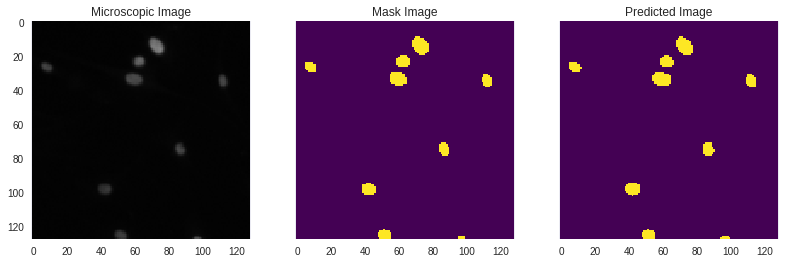

In [11]:
def display_results(id_, X_train, Y_train, predicted):
    fig, arr = plt.subplots(1, 3, figsize=(13.4, 4), sharey=True,sharex=True)
    arr[0].set_title('Microscopic Image')
    arr[0].grid(False)
    arr[0].imshow(X_train[id_])

    arr[1].set_title('Mask Image')
    arr[1].grid(False)
    arr[1].imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    
    arr[2].imshow(np.squeeze(predicted[id_]), cmap="viridis")
    arr[2].set_title('Predicted Image')
    arr[2].grid(False)
        
id_ = np.random.randint(0, len(predict_train_set))
display_results(id_, X_train, Y_train, predict_train_set)

# Visualize Test Prediction

To test how well our model working i create 4 random images from test images and check how prediction is?

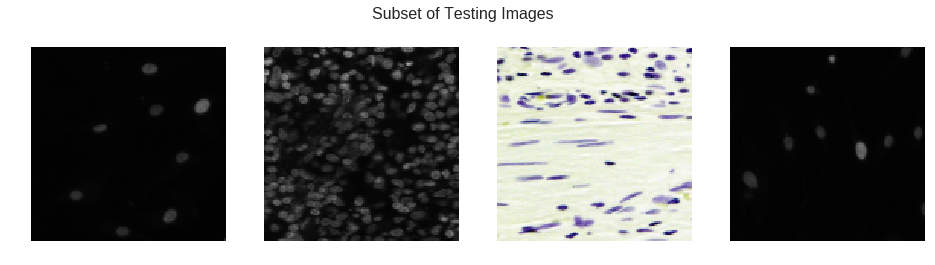

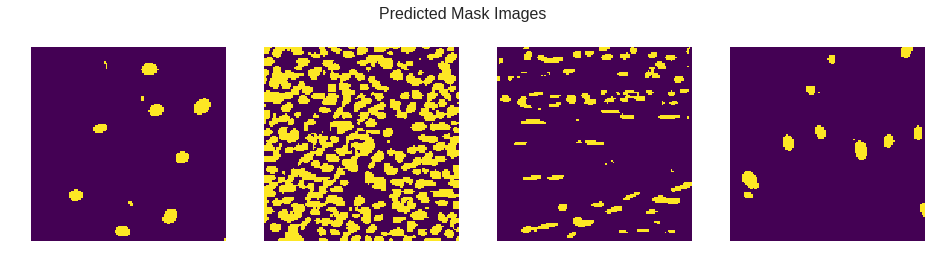

In [12]:
number_list = []

for i in range(4):
    rand = np.random.randint(0, len(X_test))
    number_list.append(rand)


# visualize subset of training data
fig = plt.figure(figsize=(16,4))
for i in range(0, len(number_list)):
    ax = fig.add_subplot(1, 4, i+1)
    ax.grid(False)
    ax.imshow(X_test[i])
    ax.axis('off')
fig.suptitle('Subset of Testing Images',  fontsize=16)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(16,4))

for i in range(0, len(number_list)):
    ax = fig.add_subplot(1, 4, i+1)
    ax.grid(False)
    ax.axis('off')
    ax.imshow(np.squeeze(predict_test_set[i]),  cmap="viridis")
fig.suptitle('Predicted Mask Images', fontsize=16)
plt.show()

# Save Results in local disks
now we save all predicted test images in local disks.

In [13]:
import png 
resultspath = os.path.join(cwd, 'results')

if not os.path.exists(resultspath):
    os.makedirs(resultspath)

for index, image in enumerate(predict_test_set):
    image_id = test_ids[index] + '.png'
    png.from_array(image, 'L').save(os.path.join(resultspath, image_id))  

print('All images saved successfully!')

All images saved successfully!
